Authors:
- Brent Gerets
- Tim Boghe

# Dataset

We use a real world [credit card transfer dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download). Most of the columns do not have a meaningful name for privacy reasons. There is also a transfer amount column and a column that indicates whether the transfer is fraudulent.

The dataset is very imbalanced, only 0.172% of the transactions are fraudulent.

# Prepare data

Load in the dataset. We do not need the time column since it is not a meaningful feature (it is the time in seconds since the first transaction in the dataset).

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('creditcard.csv', sep=',')
data = data.drop("Time", axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Split the data into train and test. The stratify parameter makes it so that the train and test sets have the same percentage of anomalies.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop("Class", axis=1), data["Class"], test_size=0.20, random_state=42, stratify=data["Class"])

Normalize the data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train and test model

Create the XGBoost classification matrices.

In [ ]:
import xgboost as xgb

train_dm = xgb.DMatrix(X_train, y_train, enable_categorical=True)
test_dm = xgb.DMatrix(X_test, y_test, enable_categorical=True)

Perform XGBoost cross validation and train the model. We use the AUC-PR metric because of the imbalance in the data.

In [ ]:
params = {"objective": "binary:logistic"}
results = xgb.cv(params, train_dm, num_boost_round=1000, nfold=5, metrics=["aucpr"])
model = xgb.train(params, train_dm, num_boost_round=1000)

Show the precision ROC and the AUC-PR.

0.8769033734249555


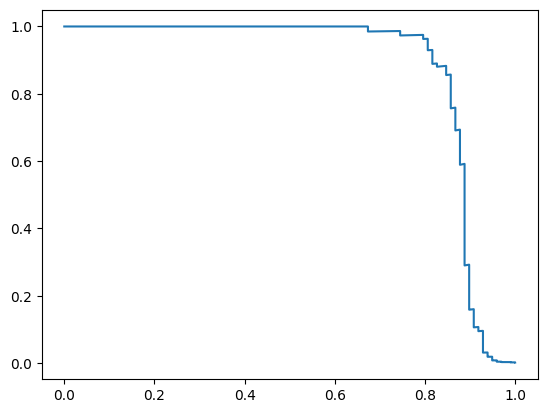

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

probabilities = model.predict(test_dm)

precision, recall, _ = precision_recall_curve(y_test, probabilities)
aucpr = auc(recall, precision)
print(aucpr)

plt.plot(recall, precision)
plt.show()